В нашем проекте мы создадим модель для предсказания цен на квартиры в Москве. В качестве обучающей выборки возьмем датасет с kaggle: https://www.kaggle.com/datasets/hugoncosta/price-of-flats-in-moscow

Для начала загрузим наш датасет

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hugoncosta/price-of-flats-in-moscow")

print("Path to dataset files:", path)

100%|██████████| 19.8k/19.8k [00:00<00:00, 14.5MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/hugoncosta/price-of-flats-in-moscow/versions/1


Импортируем все необходимое

In [8]:
pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor

In [7]:
import os

path = "/root/.cache/kagglehub/datasets/hugoncosta/price-of-flats-in-moscow/versions/1"

# Смотрим, какие файлы есть в папке
print(os.listdir(path))

['flats_moscow.csv']


In [9]:
data = pd.read_csv("/root/.cache/kagglehub/datasets/hugoncosta/price-of-flats-in-moscow/versions/1/flats_moscow.csv", index_col=0)
data

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
1,81,58,40,6.0,12.5,7,1,1,1,3
2,75,44,28,6.0,13.5,7,1,0,1,6
3,128,70,42,6.0,14.5,3,1,1,1,3
4,95,61,37,6.0,13.5,7,1,0,1,1
5,330,104,60,11.0,10.5,7,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...
2036,110,77,45,10.0,12.0,5,0,0,1,5
2037,95,60,43,6.0,9.0,5,0,0,1,4
2038,95,60,46,5.0,10.5,5,1,0,1,7
2039,129,76,48,10.0,12.5,5,0,0,1,3


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2040 entries, 1 to 2040
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     2040 non-null   int64  
 1   totsp     2040 non-null   int64  
 2   livesp    2040 non-null   int64  
 3   kitsp     2040 non-null   float64
 4   dist      2040 non-null   float64
 5   metrdist  2040 non-null   int64  
 6   walk      2040 non-null   int64  
 7   brick     2040 non-null   int64  
 8   floor     2040 non-null   int64  
 9   code      2040 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 175.3 KB


In [11]:
data.drop(columns = ['code'], inplace=True)
data

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor
1,81,58,40,6.0,12.5,7,1,1,1
2,75,44,28,6.0,13.5,7,1,0,1
3,128,70,42,6.0,14.5,3,1,1,1
4,95,61,37,6.0,13.5,7,1,0,1
5,330,104,60,11.0,10.5,7,0,1,1
...,...,...,...,...,...,...,...,...,...
2036,110,77,45,10.0,12.0,5,0,0,1
2037,95,60,43,6.0,9.0,5,0,0,1
2038,95,60,46,5.0,10.5,5,1,0,1
2039,129,76,48,10.0,12.5,5,0,0,1


Посмотрим, присутствуют ли в Nan в нашем датасете

In [12]:
data.isna().sum()

,0
price,0
totsp,0
livesp,0
kitsp,0
dist,0
metrdist,0
walk,0
brick,0
floor,0


Перед созданием и обучением модели поработаем с нашими данными, посмотрим на их распределение, проанализируем на выбросы

In [13]:
print(data['walk'].value_counts())
print(data['floor'].value_counts())
print(data['brick'].value_counts())

walk
1    1399
0     641
Name: count, dtype: int64
floor
1    1613
0     427
Name: count, dtype: int64
brick
0    1381
1     659
Name: count, dtype: int64


Стоит отметить, что колонки "walk", "brick" и "floor" являются категориальными признаками, они могут принимать только значения "0" или "1", с ними все хорошо. Посмотрим на другие фичи

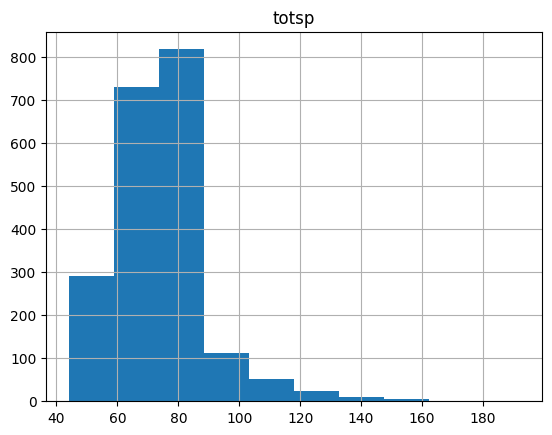

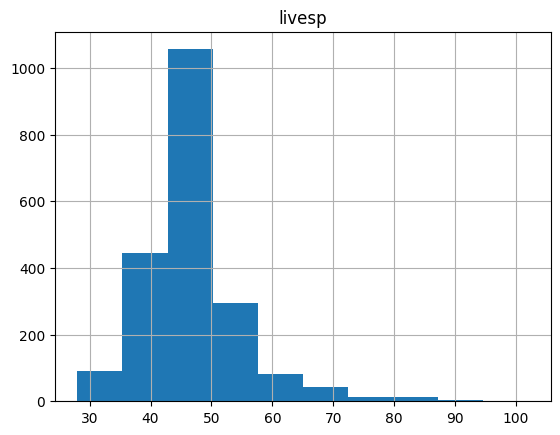

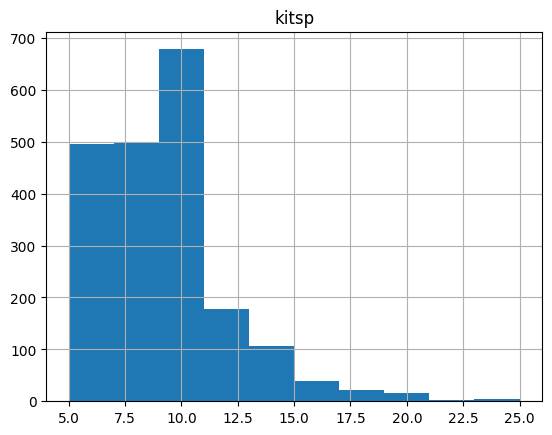

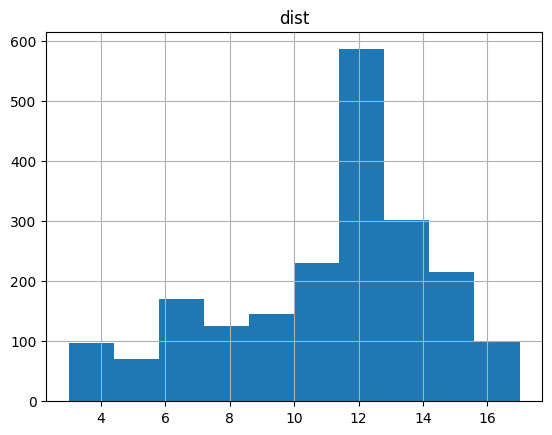

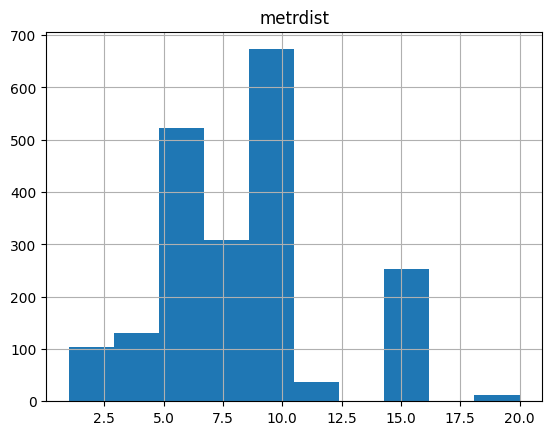

In [14]:
#отрисуем графики
for column in data.columns[1:6]:
    data.hist(column)
    plt.show()

Распредение всех колонок даже не приближено к нормальному. В колонках "totsp", "livesp" и "kitsp" имееются выбросы, судя по гистограммам. посмотрим на это подробнее, построив для них boxplots

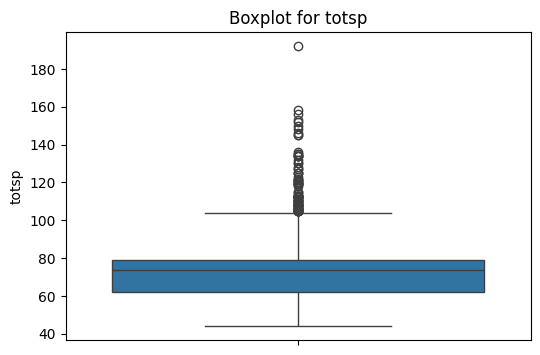

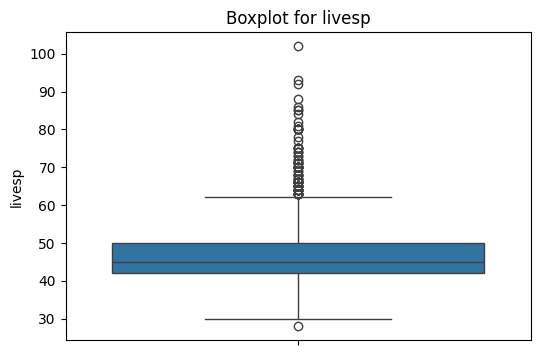

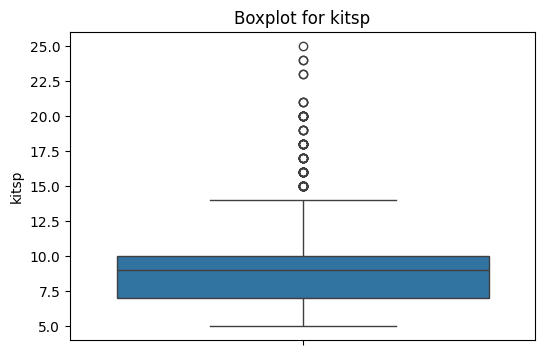

In [15]:
import seaborn as sns

for column in data.columns[1:4]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=data, y=column)
    plt.title(f"Boxplot for {column}")
    plt.show()

Удалим подобные выбросы

In [16]:
#создадим функцию удаления выбросов
def clean_outliers(data, columns):
    for column in columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        #тут фильтруем наши данные
        data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    return data

In [17]:
data = clean_outliers(data, ['totsp', 'livesp', 'kitsp'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1859 entries, 1 to 2040
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     1859 non-null   int64  
 1   totsp     1859 non-null   int64  
 2   livesp    1859 non-null   int64  
 3   kitsp     1859 non-null   float64
 4   dist      1859 non-null   float64
 5   metrdist  1859 non-null   int64  
 6   walk      1859 non-null   int64  
 7   brick     1859 non-null   int64  
 8   floor     1859 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 145.2 KB


Теперь у нас осталось всего 1859 строк. Проверим наш результат, построив "ящики с усами" еще раз

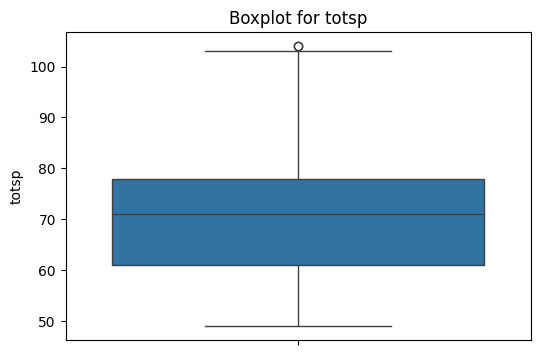

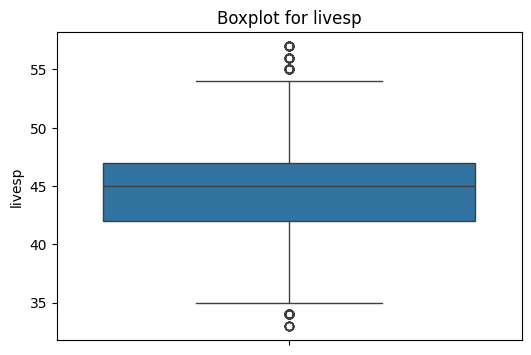

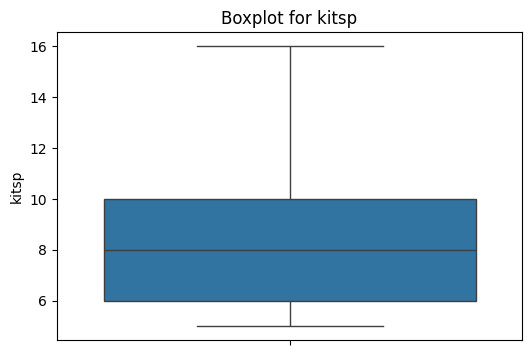

In [18]:
for column in data.columns[1:4]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=data, y=column)
    plt.title(f"Boxplot for {column}")
    plt.show()

Имеем картину гораздо лучше. Теперь посмотрим на нашу целeвую переменную

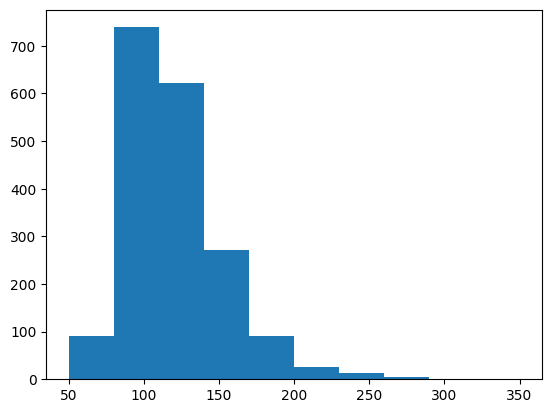

In [19]:
plt.hist(data['price'])
plt.show()

In [20]:
print(min(data['price']))
print(max(data['price']))

50
350


Имеем достаточно большую разницу между минимальным и максимальным значением. Тогда есть смысл использовать MSE в качестве метрики

Настало время создания и обучения нашей модели. Разобьем данные на тестовую и тренировочную выборки

In [21]:
from sklearn.preprocessing import StandardScaler

y = data['price']
X = data.drop(columns = ['price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train)

      totsp  livesp  kitsp  dist  metrdist  walk  brick  floor
49       60      43    6.0  12.0         5     0      1      1
114      57      40    6.0   4.5         5     1      1      1
303      71      52    8.0   8.0        10     0      1      0
1419     76      55    8.0   7.5         2     1      1      1
386      79      51   12.0   3.0         8     1      1      1
...     ...     ...    ...   ...       ...   ...    ...    ...
1238     92      50   11.0   6.5        10     1      0      1
1415     60      40    8.0  13.5         5     1      0      0
946      55      40    6.0   9.0         7     0      0      1
1603     64      40    7.0  17.0        10     1      0      0
1234     66      43    9.0   5.0        10     1      1      1

[1394 rows x 8 columns]


создадим и обучим модель

In [22]:
model = LinearRegression()

model.fit(X_train, y_train)

LinearRegression()

Замерим метрики

In [23]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

MSE: 385.14641950881156
MAE: 14.375276302027805
R2: 0.5948379079451949


Результаты не вдохновляющие. Попробуем создать и обучить случайный лес

In [24]:
from sklearn.ensemble import RandomForestRegressor

model2 = RandomForestRegressor(n_estimators=100, random_state=42)

model2.fit(X_train, y_train)

y_pred = model2.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

MSE: 333.7492614640464
MAE: 12.413511085509473
R2: 0.6489061246655948


Небольшим перебором гиперпараметра (n_estimators) нам удалось получить результат получше, чем в LinearRegression.

Попробуем использовать Ridge регрессию с перебором гиперпараметров

In [25]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


ridge = Ridge()

param_grid = {
    'alpha': [0.1, 1, 10, 100],  # Варьируем уровень регуляризации
    'solver': ['auto', 'svd', 'cholesky', 'lsqr']  # Выбор оптимизатора
}

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1
)


grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие параметры: {'alpha': 10, 'solver': 'svd'}


Замерим метрики

In [26]:
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

MSE: 384.5958570004061
MAE: 14.354463067635736
R2: 0.5954170826341274


Лучшего результата, к сожалению, нам добиться не удалось. Тогда воспользуемся библиотекой catboost

In [43]:
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.03,
    depth=7,
    l2_leaf_reg=5,
    bagging_temperature=0.5,
    loss_function='RMSE',
    random_seed=42
)

print(X_train)

model.fit(X_train, y_train, cat_features=[5, 6, 7], verbose=100)

# Предсказание и оценка
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R2:", r2)

      totsp  livesp  kitsp  dist  metrdist  walk  brick  floor
49       60      43    6.0  12.0         5     0      1      1
114      57      40    6.0   4.5         5     1      1      1
303      71      52    8.0   8.0        10     0      1      0
1419     76      55    8.0   7.5         2     1      1      1
386      79      51   12.0   3.0         8     1      1      1
...     ...     ...    ...   ...       ...   ...    ...    ...
1238     92      50   11.0   6.5        10     1      0      1
1415     60      40    8.0  13.5         5     1      0      0
946      55      40    6.0   9.0         7     0      0      1
1603     64      40    7.0  17.0        10     1      0      0
1234     66      43    9.0   5.0        10     1      1      1

[1394 rows x 8 columns]
0:	learn: 32.7407517	total: 1ms	remaining: 502ms
100:	learn: 18.4994426	total: 227ms	remaining: 896ms
200:	learn: 16.5001803	total: 384ms	remaining: 571ms
300:	learn: 15.2272611	total: 550ms	remaining: 363ms
400:	learn:

Имеем результат лучше предыдущих, досточно неплохой. Сохраним нашу модель для последующего использования в проекте

In [28]:
model.save_model("catboost_model.cbm")

Проверим корректность работы

In [34]:
# Данные для предсказания
x_new = [[17, 23, 10, 5, 11, 0, 1, 1]]

cat_features = [5, 6, 7]  # Индексы категориальных признаков

# Загрузка модели
loaded_model = CatBoostRegressor()
loaded_model.load_model("catboost_model.cbm")

# Используем загруженную модель для предсказаний
y_pred_loaded = loaded_model.predict(x_new)

print(y_pred_loaded)

[97.2267225]
